In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline
import pickle
import os
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("TransformedData.csv")
df['Posted Time'] = pd.to_datetime(df['Posted Time'], format="%d/%m/%Y")
print(df.head())

  Posted Time  Longitude  Latitude     Width    Length  Floors  Rooms  \
0  2025-01-31  10.400602  4.003590  2.236068  4.472136     0.0    0.0   
1  2025-02-01  10.398891  4.009621  2.236068  4.472136     0.0    0.0   
2  2025-01-13  10.399521  4.008289  2.236068  3.872983     0.0    0.0   
3  2025-02-02  10.397751  4.005646  2.236068  4.472136     0.0    0.0   
4  2025-02-05  10.400602  3.996527  2.236068  4.472136     0.0    0.0   

   Toilets  Price per m2  1 Part Residential  ...  House Direction_SOUTHWEST  \
0      0.0      1.252763                   1  ...                        0.0   
1      0.0      1.252763                   0  ...                        0.0   
2      0.0      1.554630                   0  ...                        0.0   
3      0.0      1.791759                   0  ...                        0.0   
4      0.0      1.642228                   0  ...                        0.0   

   House Direction_WEST  Furnishing Sell_BASIC_FINISHING  \
0                   

In [3]:
print(df.columns.tolist())

['Posted Time', 'Longitude', 'Latitude', 'Width', 'Length', 'Floors', 'Rooms', 'Toilets', 'Price per m2', '1 Part Residential', 'All Residential', 'Back Expansion', 'Car Alley', 'Frontage', 'No Residential', 'Category_HOUSE', 'Category_LAND', 'House Direction_EAST', 'House Direction_NORTH', 'House Direction_NORTHEAST', 'House Direction_NORTHWEST', 'House Direction_SOUTH', 'House Direction_SOUTHEAST', 'House Direction_SOUTHWEST', 'House Direction_WEST', 'Furnishing Sell_BASIC_FINISHING', 'Furnishing Sell_FULLY_FURNISHED', 'Furnishing Sell_HIGH_END_FURNITURE', 'Furnishing Sell_RAW_HANDOVER', 'Land Type_AGRICULTURAL_LAND', 'Land Type_INDUSTRIAL_LAND', 'Land Type_PROJECT_LAND', 'Land Type_RESIDENTIAL_LAND']


In [4]:
df['year'] = df['Posted Time'].dt.year
df['month'] = df['Posted Time'].dt.month
df['day'] = df['Posted Time'].dt.day
df['dayofweek'] = df['Posted Time'].dt.dayofweek
df['quarter'] = df['Posted Time'].dt.quarter

df.head()
df.drop(columns=['Posted Time'], inplace=True)

In [5]:
y = df['Price per m2']
X = df.drop('Price per m2', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
# train = pd.read_csv("train.csv")
# test = pd.read_csv("test.csv")

# X_train = train.drop('Price per m2', axis=1)
# y_train = train['Price per m2']
# X_test = test.drop('Price per m2', axis=1)
# y_test = test['Price per m2']

# print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

X_train: (11172, 36), X_test: (2793, 36)


In [6]:
print("\nTraining basic Random Forest model...")
basic_rf = RandomForestRegressor(n_estimators=100, random_state=42)
basic_rf.fit(X_train, y_train)


Training basic Random Forest model...


RandomForestRegressor(random_state=42)

In [7]:
y_train_pred = basic_rf.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

# Evaluate on Test Set
y_test_pred = basic_rf.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("=== Basic Random Forest Evaluation ===")
print(f"Training MSE: {mse_train:.5f}, RMSE: {rmse_train:.5f}, MAE: {mae_train:.5f}, R2: {r2_train:.5f}")
print(f"Test MSE: {mse_test:.5f}, RMSE: {rmse_test:.5f}, MAE: {mae_test:.5f}, R2: {r2_test:.5f}")

=== Basic Random Forest Evaluation ===
Training MSE: 0.00426, RMSE: 0.06527, MAE: 0.04014, R2: 0.98531
Test MSE: 0.03114, RMSE: 0.17648, MAE: 0.10644, R2: 0.89499


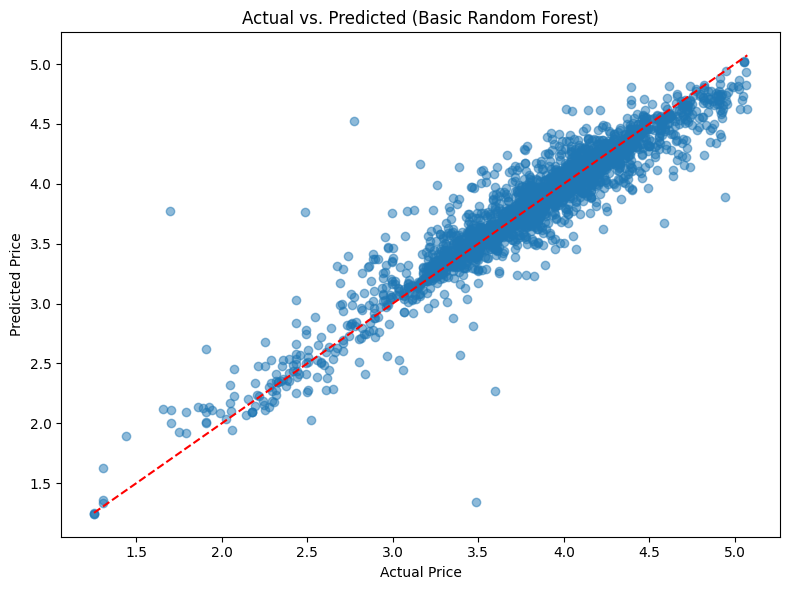

In [8]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted (Basic Random Forest)")
plt.tight_layout()
plt.show()
plt.close()

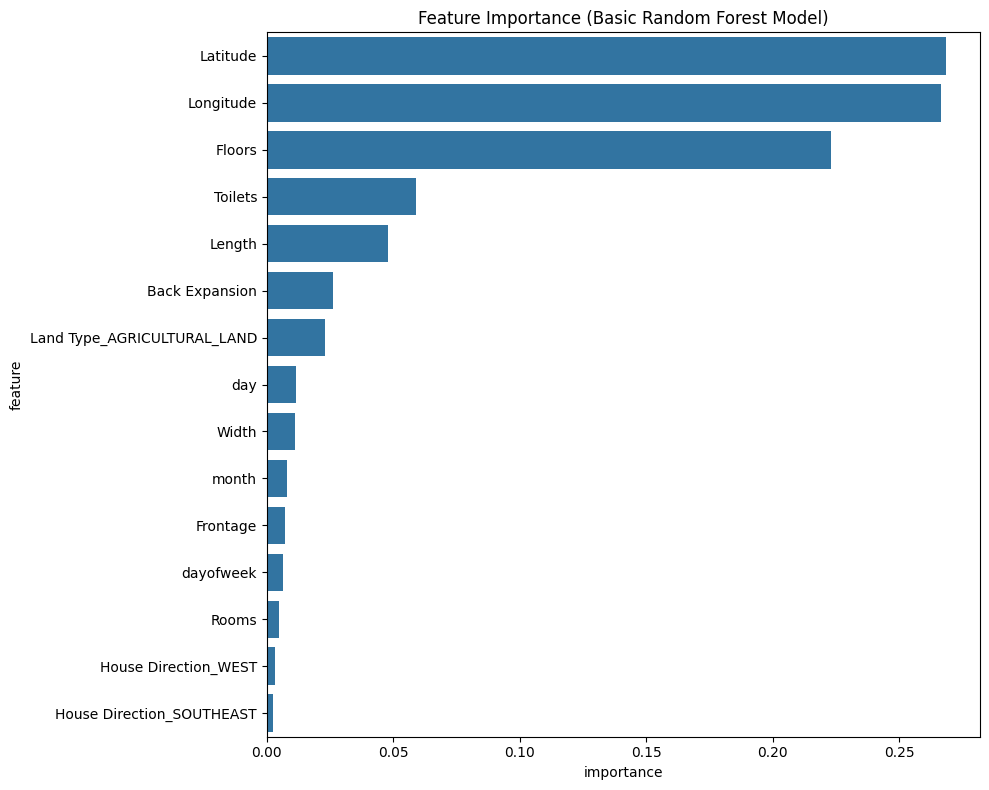

In [9]:
plt.figure(figsize=(10,8))
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': basic_rf.feature_importances_
}).sort_values('importance', ascending=False)

sns.barplot(x='importance', y='feature', data=feature_importance.head(15))
plt.title("Feature Importance (Basic Random Forest Model)")
plt.tight_layout()
plt.show()
plt.close()

In [10]:
# Smaller parameter grid for demonstration
# 

param_grid = {
    'n_estimators': [300],
    'max_depth': [20],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

rf = RandomForestRegressor(random_state=42)
grid = GridSearchCV(
    rf,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid.fit(X_train, y_train)
print("Best parameters:", grid.best_params_)
# Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}



=== Random Forest Model Evaluation ===
Training MSE: 0.00464, RMSE: 0.06812, MAE: 0.04344, R2: 0.9840
Test MSE: 0.03056, RMSE: 0.17483, MAE: 0.10593, R2: 0.8969


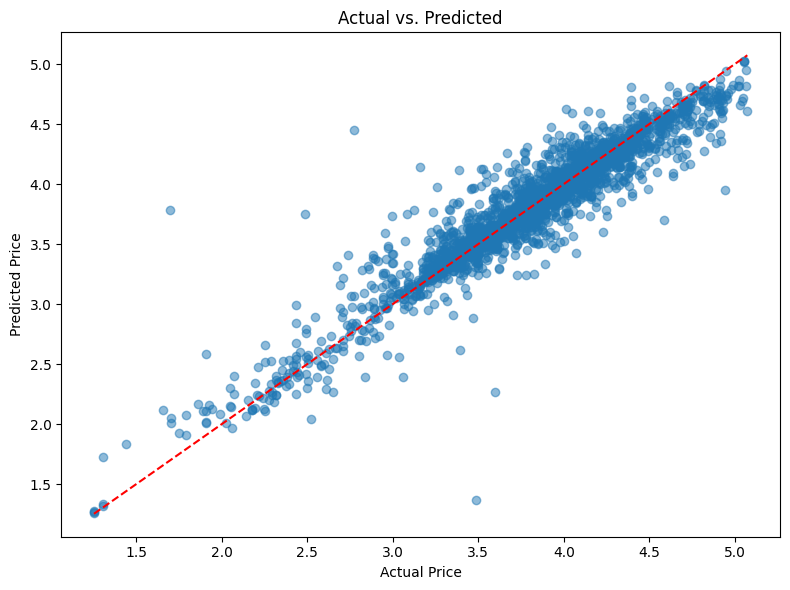

In [11]:
best_model = grid.best_estimator_
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\n=== Random Forest Model Evaluation ===")
print(f"Training MSE: {mse_train:.5f}, RMSE: {rmse_train:.5f}, MAE: {mae_train:.5f}, R2: {r2_train:.4f}")
print(f"Test MSE: {mse_test:.5f}, RMSE: {rmse_test:.5f}, MAE: {mae_test:.5f}, R2: {r2_test:.4f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted")
plt.tight_layout()
plt.show()
plt.close()

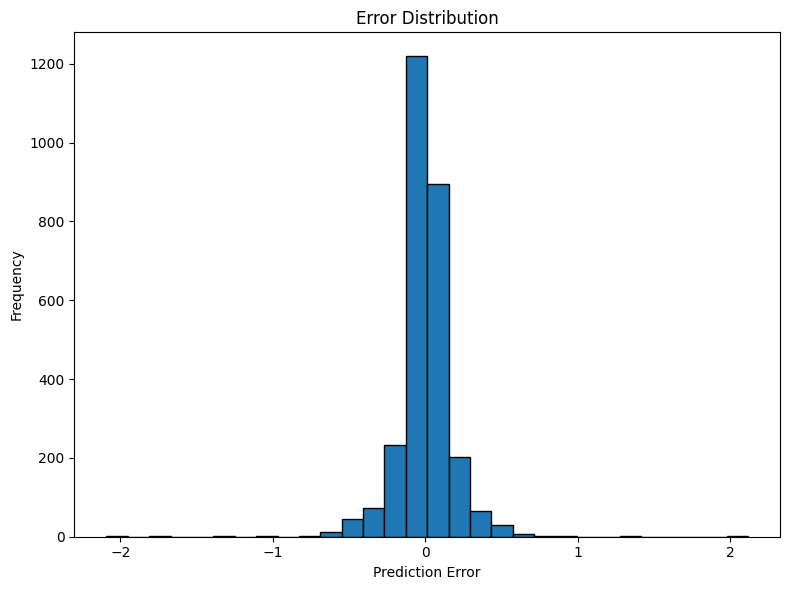


Cross-val MSE mean: 0.03406, std: 0.00162


In [12]:
errors = y_test - y_test_pred
plt.figure(figsize=(8,6))
plt.hist(errors, bins=30, edgecolor='k')
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.title("Error Distribution")
plt.tight_layout()
plt.show()
plt.close()

cv_scores = cross_val_score(
    best_model, X_train, y_train,
    cv=5, scoring='neg_mean_squared_error'
)
print("\nCross-val MSE mean: {:.5f}, std: {:.5f}".format(-cv_scores.mean(), cv_scores.std()))

In [13]:
final_model = RandomForestRegressor(**grid.best_params_, random_state=42)
final_model.fit(X, y)

RandomForestRegressor(max_depth=20, n_estimators=300, random_state=42)

In [14]:
pipeline = PMMLPipeline([
    ("regressor", final_model)
])

output_dir = '../../Backend/src/main/resources/'
os.makedirs(output_dir, exist_ok=True)

with open('RF_forecast_model.pmml', 'wb') as f:
    pickle.dump(pipeline, f)

pmml_path = os.path.join(output_dir, 'RF_forecast_model.pmml')
sklearn2pmml(pipeline, pmml_path)

with open('RF_forecast_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

pkl_path = os.path.join(output_dir, 'RF_forecast_model.pkl')
with open(pkl_path, 'wb') as f:
    pickle.dump(final_model, f)


Generating 90-day forecast...


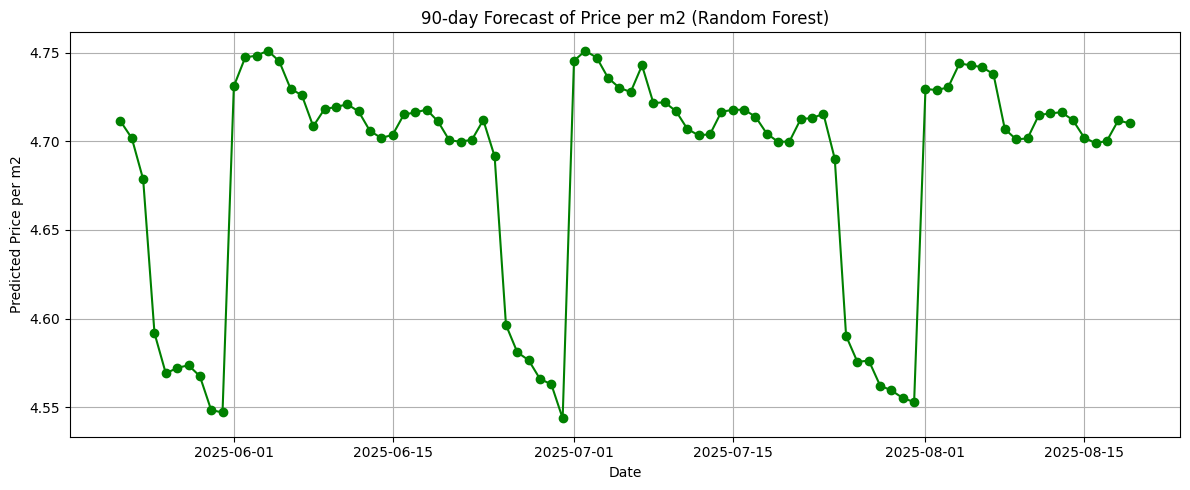

In [15]:
print("\nGenerating 90-day forecast...")
# Get baseline (latest sample)
base = X.iloc[-1].copy()

# Start date for forecasting (today)
start_date = pd.Timestamp.now().normalize()

# Generate forecasts
results = []
for i in range(90):
    date = start_date + timedelta(days=i)
    f = base.copy()
    
    # Update time features
    f['year'] = date.year
    f['month'] = date.month
    f['day'] = date.day
    f['dayofweek'] = date.weekday()
    f['quarter'] = date.quarter
    
    # Predict
    X_pred = f.values.reshape(1, -1)
    pred_price = final_model.predict(X_pred)[0]
    
    results.append({
        'Date': date,
        'Predicted_Price_per_m2': pred_price
    })

forecast_df = pd.DataFrame(results)

# Save forecast results
forecast_df.to_csv('random_forest_forecast_results.csv', index=False)

# Plot forecast
plt.figure(figsize=(12, 5))
plt.plot(forecast_df['Date'], forecast_df['Predicted_Price_per_m2'], marker='o', color='green')
plt.title('90-day Forecast of Price per m2 (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Predicted Price per m2')
plt.grid(True)
plt.tight_layout()
plt.show()